In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


In [2]:
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
import unicodedata
import string
import time 
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Data Pre-Processing 
First step to start with NLP problem is to preprocess the text data

In [3]:
!pip install contractions
# spelling correction 
!pip install symspellpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 46.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.5/125.5 kB 13.5 MB/s eta 0:00:00


In [31]:
df_train = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv',encoding = 'latin-1')
print(df_train.shape)
df_train.head()

(1599999, 6)


,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [32]:
# renaming columns
df_train = df_train.rename(columns = {'0':'target',"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D" : 'text'})

In [35]:
# Extracting the tweets which can be relevant to stock price changes
df_train = df_train[df_train['text'].str.contains('stock| Stock | stockmarket|tech|MSFT|microsoft edge|AAPL| google|windows| tesla | microsoft | amazon | meta | facebook |alphabet | nvidia | paypal | intel |comcast |Cisco system | pepsico |Broadcom | Texas Instruments |T-Mobile | Costco |Qualcomm ')]

In [36]:
print(df_train.shape)
df_train.head()

(8358, 6)


,target,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,text
225,0,1467871844,Mon Apr 06 22:35:44 PDT 2009,NO_QUERY,larsgunnarf,Tuesdayï¿½ll start with reflection ï¿½n then a...
285,0,1467881920,Mon Apr 06 22:38:28 PDT 2009,NO_QUERY,mumu1210,"FML: So much for seniority, bc of technologica..."
331,0,1467895712,Mon Apr 06 22:42:10 PDT 2009,NO_QUERY,larabehnert,"@trishzw megafast trip, you have time during d..."
368,0,1467905653,Mon Apr 06 22:44:57 PDT 2009,NO_QUERY,KishoreK,@nchokkan https://www.mycomicshop.com/search?T...
415,0,1467917177,Mon Apr 06 22:48:08 PDT 2009,NO_QUERY,nchokkan,"@KishoreK this is strange, illegal torrents av..."


In [37]:
df_train = df_train.drop(['1467810369','Mon Apr 06 22:19:45 PDT 2009','NO_QUERY','_TheSpecialOne_'],axis = 1)

In [38]:
df_train

,target,text
225,0,Tuesdayï¿½ll start with reflection ï¿½n then a...
285,0,"FML: So much for seniority, bc of technologica..."
331,0,"@trishzw megafast trip, you have time during d..."
368,0,@nchokkan https://www.mycomicshop.com/search?T...
415,0,"@KishoreK this is strange, illegal torrents av..."
...,...,...
1599783,4,@bucketofsunshyn another majestic place. this ...
1599796,4,As reported by @jedwhite there are definitely ...
1599892,4,@SouthMainMuse Perfectly normal. Thinking som...
1599899,4,@cris1015 My goal on stocks like $MTXX is to h...


In [39]:
df_train.loc[df_train['target'] == 4,'target'] = 1
df_train

,target,text
225,0,Tuesdayï¿½ll start with reflection ï¿½n then a...
285,0,"FML: So much for seniority, bc of technologica..."
331,0,"@trishzw megafast trip, you have time during d..."
368,0,@nchokkan https://www.mycomicshop.com/search?T...
415,0,"@KishoreK this is strange, illegal torrents av..."
...,...,...
1599783,1,@bucketofsunshyn another majestic place. this ...
1599796,1,As reported by @jedwhite there are definitely ...
1599892,1,@SouthMainMuse Perfectly normal. Thinking som...
1599899,1,@cris1015 My goal on stocks like $MTXX is to h...


In [40]:
df_test = pd.read_csv('/kaggle/input/test-data/test_data.csv')
print(df_test.shape)
df_test.head()

(5791, 1)


,Text
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...
2,user I'd be afraid to short AMZN - they are lo...
3,MNTA Over 12.00
4,OI Over 21.37


In [41]:
print(df_train.isnull().sum())
print(df_test.isnull().sum())

target    0
text      0
dtype: int64
Text    0
dtype: int64


cheking a label 1 and label 0 example

In [42]:
df_train[df_train['target']==1]['text'].values[20]

'@natztheflip aw, you guys are the best! haha. save me from making a fool outta myself with all this technology '

In [43]:
df_train[df_train['target']!=1]['text'].values[20]

"@aventure That's windows for you... I get to deal with about 20 windows servers and 180 windows machines misbehaving every day..  shoot me"

In [44]:
print(df_train['target'].value_counts())

1    4254
0    4104
Name: target, dtype: int64


([<matplotlib.patches.Wedge at 0x7575cc60d150>,
 [Text(-0.03100580501351785, 1.0995629313756734, 'negative'),
  Text(0.031005702065006673, -1.0995629342786415, 'positive')])

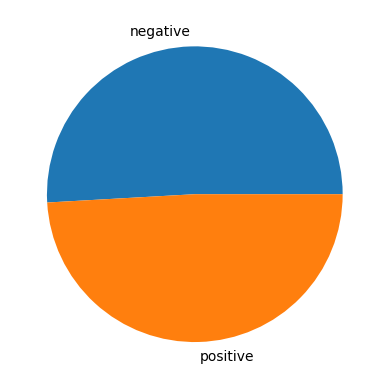

In [46]:
plt.pie(df_train['target'].value_counts(),labels = ['negative','positive'])

**Preprocessing of Data**
(train and test both)

In [49]:
df_train = df_train.rename(columns = {"text" : 'tweet'})
df_test = df_test.rename(columns = {"Text" : 'tweet'})
df_train.head()

,target,tweet
225,0,Tuesdayï¿½ll start with reflection ï¿½n then a...
285,0,"FML: So much for seniority, bc of technologica..."
331,0,"@trishzw megafast trip, you have time during d..."
368,0,@nchokkan https://www.mycomicshop.com/search?T...
415,0,"@KishoreK this is strange, illegal torrents av..."


Now all the preprocessing will be done on this new coloumn **tweet**

In [50]:
df_train['tweet'] =  df_train['tweet'].str.lower()
df_test['tweet'] =  df_test['tweet'].str.lower()

In [51]:
def remove_html(text):
    soup = BeautifulSoup(text)
    text = soup.get_text()
    return text

df_train["tweet"] = df_train['tweet'].apply(remove_html)
df_test["tweet"] = df_test['tweet'].apply(remove_html)

In [52]:
# Expanding Contraxctions
import contractions
df_train['tweet'] = df_train['tweet'].apply(contractions.fix)
df_test['tweet'] = df_test['tweet'].apply(contractions.fix)

In [53]:
# removing URLs
def remove_URL(text):
    pattern = re.compile(r'https?://(www\.)?(\w+)(\.\w+)(/\w*)?')
    text = re.sub(pattern , "",text)
    return text

df_train['tweet'] = df_train['tweet'].apply(remove_URL)
df_test['tweet'] = df_test['tweet'].apply(remove_URL)

In [54]:
# removing Email ids
def remove_email(text):
    pattern = re.compile(r"[\w\.-]+@[\w\.-]+\.\w+")
    text = re.sub(pattern,"",text)
    return text

df_train['tweet'] = df_train['tweet'].apply(remove_email)
df_test['tweet'] = df_test['tweet'].apply(remove_email)

In [55]:
def remove_mentions(text):
    pattern = re.compile(r"@\w+")
    text = re.sub(pattern, "", text)
    return text

df_train['tweet'] = df_train['tweet'].apply(remove_mentions)
df_test['tweet'] = df_test['tweet'].apply(remove_mentions)

In [56]:
# removing accented words like résumé
from unidecode import unidecode
def remove_unicode(text):
#     text = text.encode("ascii", "ignore").decode()
    return unidecode(text)

# print(remove_unicode('résumé'))
# print(unidecode('résumé'))
df_train['tweet'] = df_train['tweet'].apply(remove_unicode)
df_test['tweet'] = df_test['tweet'].apply(remove_unicode)

In [57]:
# Removing punctuations
punctuations = string.punctuation

def remove_punctuations(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), " ",text)
    return text

df_train['tweet'] = df_train['tweet'].apply(remove_punctuations)
df_test['tweet'] = df_test['tweet'].apply(remove_punctuations)

In [58]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
# print(stop_words)

def remove_stopWords(text):
    return ' '.join([word for word in str(text).split() if word not in stop_words])

df_train['tweet'] = df_train['tweet'].apply(remove_stopWords)
df_test['tweet'] = df_test['tweet'].apply(remove_stopWords)

In [59]:
def remove_extra_spaces(text):
    text = re.sub(' +', ' ', text).strip()
    return text

df_train['tweet'] = df_train['tweet'].apply(remove_extra_spaces)
df_test['tweet'] = df_test['tweet'].apply(remove_extra_spaces)

In [60]:
import nltk

nltk.download('wordnet')
nltk.download('wordnet2022')

! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet2022 to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/wordnet2022.zip.


In [61]:
# Lemmatization
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def Lemmatize_text(text):
    words = [lemmatizer.lemmatize(word) for word in str(text).split()]
    text = ' '.join(words)
    return text

df_train['tweet'] = df_train['tweet'].apply(Lemmatize_text)
df_test['tweet'] = df_test['tweet'].apply(Lemmatize_text)

In [62]:
import pkg_resources
from symspellpy import SymSpell , Verbosity

sym_spell = SymSpell(max_dictionary_edit_distance = 2 , prefix_length = 7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

def correct_spelling(text):
        words = [sym_spell.lookup(word,Verbosity.CLOSEST , max_edit_distance = 2,include_unknown=True)[0].term for word in str(text).split()]
        text = ' '.join(words)
        return text
    
df_train['tweet'] = df_train['tweet'].apply(correct_spelling)
df_test['tweet'] = df_test['tweet'].apply(correct_spelling)

Now all the preprocessing has been done, let's have a look at the train and test datasets

In [63]:
df_train['tweet'].sample(5,random_state = 42)

1264042                                a misunderstood sorry
525301     twitteriffic serious technological difficulty ...
1203819    remote support like never seen much bombay abs...
967358                      am cannot sleep add facebook one
1341220      low switch raining lately window desk know like
Name: tweet, dtype: object

In [64]:
df_test['tweet'].sample(5,random_state = 42)

1891                          map take chatter know laugh
1550    amen a 200 lot bid feb weekly 255p of delta co...
1049    to made sugar sold local cost consumer prefer ...
2523    and another american institution sold foreign ...
156     watch close carefully decide whether on shot m...
Name: tweet, dtype: object

In [65]:
# downloading Pre-trained GloVe embedding 
! wget http://nlp.stanford.edu/data/glove.6B.zip
! unzip glove.6B.zip
! ls -lat

--2023-04-08 05:32:13--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-04-08 05:32:14--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-08 05:32:14--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [66]:
vocab , embedding = [],[]
with open('/kaggle/working/glove.6B.100d.txt','rt') as fi:
    full_content = fi.read().strip().split('\n')

In [67]:
vocab , embeddings = [],[]
for fi in full_content:
    word = fi.split(' ')[0]
    embed = [float(p) for p in fi.split(' ')[1:]]
    
    vocab.append(word)
    embeddings.append(embed)

In [68]:
print(vocab[0])
print(embeddings[0])

the
[-0.038194, -0.24487, 0.72812, -0.39961, 0.083172, 0.043953, -0.39141, 0.3344, -0.57545, 0.087459, 0.28787, -0.06731, 0.30906, -0.26384, -0.13231, -0.20757, 0.33395, -0.33848, -0.31743, -0.48336, 0.1464, -0.37304, 0.34577, 0.052041, 0.44946, -0.46971, 0.02628, -0.54155, -0.15518, -0.14107, -0.039722, 0.28277, 0.14393, 0.23464, -0.31021, 0.086173, 0.20397, 0.52624, 0.17164, -0.082378, -0.71787, -0.41531, 0.20335, -0.12763, 0.41367, 0.55187, 0.57908, -0.33477, -0.36559, -0.54857, -0.062892, 0.26584, 0.30205, 0.99775, -0.80481, -3.0243, 0.01254, -0.36942, 2.2167, 0.72201, -0.24978, 0.92136, 0.034514, 0.46745, 1.1079, -0.19358, -0.074575, 0.23353, -0.052062, -0.22044, 0.057162, -0.15806, -0.30798, -0.41625, 0.37972, 0.15006, -0.53212, -0.2055, -1.2526, 0.071624, 0.70565, 0.49744, -0.42063, 0.26148, -1.538, -0.30223, -0.073438, -0.28312, 0.37104, -0.25217, 0.016215, -0.017099, -0.38984, 0.87424, -0.72569, -0.51058, -0.52028, -0.1459, 0.8278, 0.27062]


In [69]:
vocab  = np.asarray(vocab)
embeddings = np.asarray(embeddings)

print(type(vocab))
print(type(embeddings))
print(embeddings.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(400000, 100)


In [70]:
PAD_TOK, UNK_TOK = ' ',''
vocab = np.concatenate([[PAD_TOK, UNK_TOK],vocab])
embeddings = np.concatenate([np.zeros((1,embeddings.shape[1])),np.mean(embeddings,axis=0,keepdims=1),embeddings],axis=0)

print(vocab.shape)
print(embeddings.shape)


(400002,)
(400002, 100)


In [72]:
# importing torch and necessary modules
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset, random_split

Checkning for cuda

In [73]:
# checking for cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'using device : {device}')

using device : cuda


A dictionary that contains all the hyper-parameters

In [102]:
# Hyper_parameters
hyper_parameters = {
    'batch_size' : 32,
    'max_seq_length' : 64,
    'freeze_embedding': True,
    'lr' : 0.0001,
    'hidden_size' : 256,
    'num_layers' :2,
    'out_size':1,
    'dropout_prob':2e-1,
    
    # Embedding Parameters
    'pretrained_embedding': embeddings,
    'vocab' : vocab,
    'pad_token' : PAD_TOK,
    'unk_token' : UNK_TOK
    
}

GRUDataset will convert the text data to there corresponding input ids

In [103]:
class GRUDataset(torch.utils.data.Dataset):
    def __init__(self,df,vocab,max_seq_length, pad_token, unk_token):
        self.labels = df.target.tolist()
        self.word2idx = {word : idx for idx,word in enumerate(vocab)}
        self.idx2word = {idx : word for idx , word in self.word2idx.items()}
        
        self.pad_token = pad_token
        self.unk_token = unk_token
#         self.max_seq_length = max_seq_length
#         Creating empty lists to store input data
        
        self.input_ids = []
        self.sequence_len = []
        self.labels = []
        
        for i in range(df.shape[0]):
            input_id , seq_len = self.convert_text_to_input_ids(df.iloc[i].tweet, max_seq_length)
            
            self.input_ids.append(input_id.reshape(-1))
            self.sequence_len.append(seq_len)
            self.labels.append(df.iloc[i].target)
        
    def convert_text_to_input_ids(self,text,pad_to_len):
        words = text.strip().split()[:pad_to_len]
        deficit = pad_to_len - len(words)
        words.extend([self.pad_token]*deficit)
        for i in range(len(words)):
            if words[i] not in self.word2idx:
                words[i] = self.word2idx[self.unk_token]
            else:
                words[i] = self.word2idx[words[i]]
        
        return torch.Tensor(words).long(), pad_to_len-deficit
        
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self,sample_id):
        sample_dict = dict()
        sample_dict['input_ids'] = self.input_ids[sample_id].reshape(-1)
        sample_dict['sequence_len'] = torch.tensor(self.sequence_len[sample_id]).long()
        sample_dict['labels'] = torch.tensor(self.labels[sample_id])
        return sample_dict

# GRU Model Defination

In [109]:
# Creating a GRU model
class ModelGRU(nn.Module):
    def __init__(self,hyper_parameters):
        super(ModelGRU,self).__init__()
        
        self.hidden_size = hyper_parameters['hidden_size']
        self.out_size = hyper_parameters['out_size']
        self.num_layers = hyper_parameters['num_layers']
        self.dropout_prob = hyper_parameters['dropout_prob']
        
        pretrained_embedding = hyper_parameters['pretrained_embedding']
        self.vocab_size = pretrained_embedding.shape[0]
        self.embedding_dim = pretrained_embedding.shape[1]
        self.embedding = torch.nn.Embedding.from_pretrained(torch.from_numpy(pretrained_embedding).float(),freeze = hyper_parameters['freeze_embedding'])
        
        self.gru = nn.GRU(input_size = self.embedding_dim , hidden_size = self.hidden_size , num_layers = self.num_layers, batch_first  =True)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(self.dropout_prob)
        self.fc1 = nn.Linear(self.hidden_size , 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(self.dropout_prob)
        self.fc2 = nn.Linear(128 , 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(self.dropout_prob)
        self.fc3 = nn.Linear(64 , 16)
        self.bn3 = nn.BatchNorm1d(16)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(self.dropout_prob)
        self.fc4 = nn.Linear(16 , 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,batch):
        x = batch['input_ids'].to(device)
#         x = batch['input_ids']
        x_length = batch['sequence_len']
        
        h_0 = torch.zeros(self.num_layers,x.size(0),self.hidden_size,requires_grad=True).to(device)
#         h_0 = torch.zeros(self.num_layers,x.size(0),self.hidden_size,requires_grad=True)
        out = self.embedding(x)
        out,_ = self.gru(out,h_0)
        out = self.relu1(out)
        out = out[:,-1,:]
        out = self.dropout1(out)
        out = self.fc1(out)
        out = self.bn1(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu3(out)
        out = self.dropout3(out)
        out = self.fc3(out)
        out = self.bn3(out)
        out = self.relu4(out)
        out = self.dropout4(out)
        out = self.fc4(out)
        out = self.sigmoid(out)
        
        return out

In [110]:
GRU2 = ModelGRU(hyper_parameters).to(device)
GRU2

ModelGRU(
  (embedding): Embedding(400002, 100)
  (gru): GRU(100, 256, num_layers=2, batch_first=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=64, out_features=16, bias=True)
  (bn3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (dropout4): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

# defining Loss criterion and optimizer

In [111]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(GRU2.parameters(),lr = hyper_parameters['lr'])
print(criterion)
print(optimizer)

BCELoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.0001
    maximize: False
    weight_decay: 0
)


Loading the data into DataLoader

In [112]:
complete_data = GRUDataset(df_train,vocab,hyper_parameters['max_seq_length'],hyper_parameters['pad_token'],hyper_parameters['unk_token'])

train_data_size = int(len(complete_data) *0.8)
val_data_size = len(complete_data) - train_data_size

train_set,val_set = random_split(complete_data,[train_data_size,val_data_size])

train_dataloader = DataLoader(train_set,batch_size  = hyper_parameters['batch_size'],shuffle = True)
val_dataloader = DataLoader(val_set,batch_size  = 1,shuffle = True)

In [113]:
# Trainig Loop
num_epoch = 1000
print_step = 100
GRU2.train()
for epoch in tqdm(range(num_epoch)):
    for input_dict in train_dataloader:
        input_dict = input_dict
#         labels = input_dict['labels'].to(device)
        labels = input_dict['labels'].to(torch.float32).to(device)
        out = GRU2(input_dict)
        loss = criterion(out,labels.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if((epoch+1)%print_step == 0):
        print(f'step [{(epoch+1)/print_step}/{num_epoch/print_step}], loss = {loss.item() :.7f}')
        

 10%|█         | 100/1000 [04:14<38:38,  2.58s/it]

step [1.0/10.0], loss = 0.6940475


 20%|██        | 200/1000 [08:28<34:38,  2.60s/it]

step [2.0/10.0], loss = 0.6955143


 30%|███       | 300/1000 [12:42<30:03,  2.58s/it]

step [3.0/10.0], loss = 0.2460421


 40%|████      | 400/1000 [16:56<25:43,  2.57s/it]

step [4.0/10.0], loss = 0.0082857


 50%|█████     | 500/1000 [21:09<21:20,  2.56s/it]

step [5.0/10.0], loss = 0.2401123


 60%|██████    | 600/1000 [25:22<16:56,  2.54s/it]

step [6.0/10.0], loss = 0.1065305


 70%|███████   | 700/1000 [29:35<12:42,  2.54s/it]

step [7.0/10.0], loss = 0.0007793


 80%|████████  | 800/1000 [33:48<08:26,  2.53s/it]

step [8.0/10.0], loss = 0.0000772


 90%|█████████ | 900/1000 [38:01<04:13,  2.53s/it]

step [9.0/10.0], loss = 0.0005380


100%|██████████| 1000/1000 [42:14<00:00,  2.53s/it]

step [10.0/10.0], loss = 0.0000974


In [114]:
def our_prediction(out):
    if out[0][0] >= 0.5:
        return np.array([1])
    return np.array([0])

# checking the accuracy of Model on validation set

In [115]:
with torch.no_grad():
    n_correct = int(0)
    n_samples = int(0)
    GRU2.eval()
    for input_dict in val_dataloader:
        out = GRU2(input_dict).detach().cpu()
        pred = our_prediction(out)
        actual_label = input_dict['labels'].detach().cpu().numpy()

        n_samples += actual_label.shape[0]
        for i in range(len(pred)):
            if actual_label[i] == pred[i]:
                n_correct += 1
        
    
    print(f'n_correct = {n_correct}' )
    print(f'n_samples = {n_samples}' )
    print(f'Accuracy_val = {(n_correct/n_samples)*100} %')

n_correct = 1111
n_samples = 1672
Accuracy_val = 66.44736842105263 %


In [116]:
# prediction on test data
df_test['target'] = 0
df_test.head()

,tweet,target
0,kicker watchlist side tit so pink cow biz a tr...,0
1,user map movie of return few need indicator of...,0
2,user would afraid short amen looking like near...,0
3,meta of of,0
4,of of of,0


In [117]:
# Predicting the targer labels on given test data
test_data = GRUDataset(df_test,vocab,hyper_parameters['max_seq_length'],hyper_parameters['pad_token'],hyper_parameters['unk_token'])
test_dataloader = DataLoader(test_data,batch_size  = 1,shuffle = True)

In [118]:
our_pred_test = []
with torch.no_grad():
    for input_dict in test_dataloader:
        out = GRU2(input_dict)
        pred = our_prediction(out)
        our_pred_test.append(pred)


In [119]:
our_pred_test = np.asarray(our_pred_test)
our_pred_test.shape

(5791, 1)

In [120]:
# df_our_submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
df_our_submission = pd.DataFrame()
df_our_submission['tweet'] = df_test['tweet']
df_our_submission['target'] = our_pred_test
print(df_our_submission.shape)
df_our_submission.head()

(5791, 2)


,tweet,target
0,kicker watchlist side tit so pink cow biz a tr...,1
1,user map movie of return few need indicator of...,0
2,user would afraid short amen looking like near...,1
3,meta of of,0
4,of of of,0


In [121]:
df_our_submission['target'] = our_pred_test

In [122]:
df_our_submission.to_csv('Submission.csv',index=False)

In [123]:
PATH = '/kaggle/working/our_model'
torch.save(GRU2.state_dict(), PATH)

# Techniques like early stopping and use of predefined models like Bert can improve the accuracy of model